In [11]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
%matplotlib inline

In [12]:
from pred_learn.models import AE_Predictor
from pred_learn.models.vae_wm import VAE
from pred_learn.data.data_container import ObservationSeriesDataset, ObservationDataset

In [13]:
# ENV_ID = "Catcher-ple-v0"
# ENV_ID = "Pong-ple-v0"
ENV_ID = "TetrisA-v2"
# ENV_ID = "PixelCopter-ple-v0"
# ENV_ID = "CarRacing-v0"
action_space_n = 10
dataset_train = ObservationSeriesDataset("../recorded/{}/0.torch".format(ENV_ID), action_space_n, 5, subtract_average=False)
train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=2
)

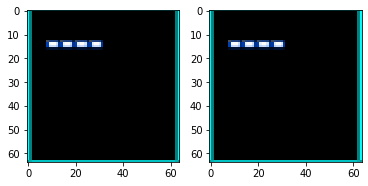

In [14]:
# replay record
with torch.no_grad():
    for i in range(10):
        timestep = dataset_train[i]
        obs = timestep["s0"][0, ...]
#         obs = timestep["s0"]
        
        clear_output(True)
        plt.subplot(121)
        plt.imshow(obs.permute([2,1,0]))
    #     obs = resize(obs, (64, 64))
        plt.subplot(122)
#         obs = model(timestep["s0"].unsqueeze(0).cuda())[0].squeeze(0).cpu()
        plt.imshow(obs.permute([2,1,0]))

    #     plt.imshow(timestep["s0"])
#         print("reward", timestep['r1'])
#         print("action", timestep['a0'])
        plt.pause(0.01)

In [15]:
model = AE_Predictor(action_space_n).cuda()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss().cuda()
losses = []

In [16]:
# torch.autograd.set_detect_anomaly(True)
for i_epoch in range(20):
    for i_batch, batch in enumerate(train_loader):
        model.zero_grad()
        obs_in = batch["s0"].cuda()
        actions = batch["a0"].cuda()
        obs_target = batch["s1"].cuda()

        obs_recon, obs_preds = model.generate_predictions(obs_in, actions)
        loss = loss_fn(obs_preds, obs_target)
#         loss = loss_fn(obs_recon, obs_in)
        losses.append(loss.item())
        loss.backward()
        optimiser.step()

        if i_batch % 10 == 0:
            clear_output()
            plt.plot(np.log(losses))
            plt.show()


        if i_batch % 101 == 0:
            clear_output()
#             plt.imshow(obs_recon[0, -1].detach().cpu().permute([2,1,0]))
            plt.imshow(obs_recon[0, -1].detach().cpu().permute([2,1,0]))
            plt.pause(1)


KeyboardInterrupt: 

In [17]:
obs_recon.max()

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)

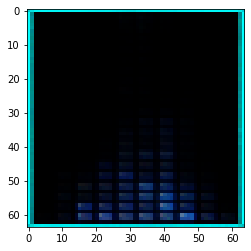

In [18]:
plt.imshow(obs_recon[0, -1].detach().cpu().permute([2,1,0]))

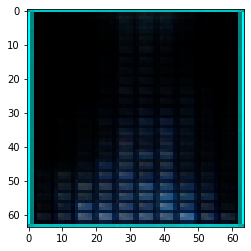

In [20]:
plt.imshow(obs_preds[0, -1].detach().cpu().permute([2,1,0]))

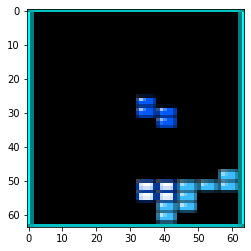

In [10]:
plt.imshow(obs_target[0, 1].detach().cpu().permute([2,1,0]))


In [96]:
for i_batch, batch in enumerate(train_loader):
    model.zero_grad()
    obs_in = batch["s0"].cuda()
    actions = batch["a0"].cuda()

    o_series = obs_in
    a_series = actions

    belief = None
    o_recons = []
    o_predictions = []
    for t in range(o_series.size(1)):
        o_0 = o_series[:, t, ...]
        a_0 = a_series[:, t, ...]
        # r_t = r_series[:, t, ...]

        o_0_enc = model.image_encoder(o_0).unsqueeze(1)
        # TODO add masking of o_t_enc (skip for initial ts)
        out, belief = model.measurement_updater(o_0_enc, belief)

        o_recon = model.image_decoder(out)
        o_recons.append(o_recon.unsqueeze(1))

        a_0_enc = model.action_encoder(a_0).unsqueeze(1)
        out, belief = model.action_propagator(a_0_enc, belief)
        # TODO add masking of null actions
        out, belief = model.env_propagator(out, belief)
        o_prediction = model.image_decoder(out)
        o_predictions.append(o_prediction.unsqueeze(1))

    o_recons = torch.cat(o_recons, dim=1)
o_predictions = torch.cat(o_predictions, dim=1)

KeyboardInterrupt: 

In [97]:
from pred_learn.models.ae import SimpleAE

In [98]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [99]:
model = SimpleAE().cuda()
optimiser = torch.optim.RMSprop(model.parameters(), lr=0.001)
# optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

# scheduler = ReduceLROnPlateau(optimiser, 'min')
loss_fn = torch.nn.MSELoss().cuda()
losses = []

In [100]:
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

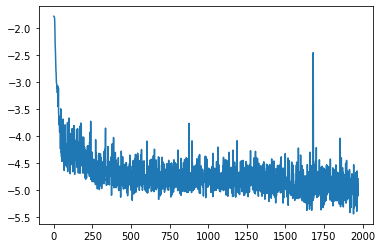

In [ ]:
for i_batch, batch in enumerate(train_loader):
    model.zero_grad()
    obs_in = batch["s0"][:, 0, ...].cuda()
#     actions = batch["a0"].cuda()
#     obs_target = batch["s1"].cuda()
    
    obs_recon = model(obs_in)
    loss = loss_fn(obs_recon, obs_in)# + loss_fn(obs_preds, obs_target)
    losses.append(loss.item())
    loss.backward()
    optimiser.step()
#     scheduler.step(loss.item())
    
    if i_batch % 10 == 0:
        clear_output()
        plt.plot(np.log(losses))
        plt.show()

        
    if i_batch % 101 == 0:
        clear_output()
        plt.imshow(obs_recon[0].detach().cpu().permute([2,1,0]))
        plt.pause(1)


In [ ]:
scheduler.best

In [21]:
model = VAE(3, 64).cuda()
optimiser = torch.optim.RMSprop(model.parameters(), lr=0.001)
from pred_learn.models.vae_wm import loss_function as loss_fn
losses = []

In [22]:
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)

In [23]:
for i_epoch in range(20):
    for i_batch, batch in enumerate(train_loader):
        model.zero_grad()
        obs_in = batch["s0"][:, 0, ...].cuda()
    #     actions = batch["a0"].cuda()
    #     obs_target = batch["s1"].cuda()

        obs_recon, mu, logsigma = model(obs_in)
        loss = loss_fn(obs_recon, obs_in, mu, logsigma)# + loss_fn(obs_preds, obs_target)
        losses.append(loss.item())
        loss.backward()
        optimiser.step()

        if i_batch % 10 == 0:
            clear_output()
            plt.plot(np.log(losses))
            plt.show()


        if i_batch % 100 == 0:
            clear_output()
            plt.imshow(obs_recon[0].detach().cpu().permute([2,1,0]))
            plt.pause(0.1)


KeyboardInterrupt: 

In [24]:
obs_recon.max()

tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)

(array([11269.,   109.,    29.,    14.,   118.,   152.,    26.,   228.,
           72.,   271.]),
 array([5.6841976e-15, 9.9998258e-02, 1.9999652e-01, 2.9999477e-01,
        3.9999303e-01, 4.9999130e-01, 5.9998953e-01, 6.9998783e-01,
        7.9998606e-01, 8.9998436e-01, 9.9998260e-01], dtype=float32),
 <a list of 10 Patch objects>)

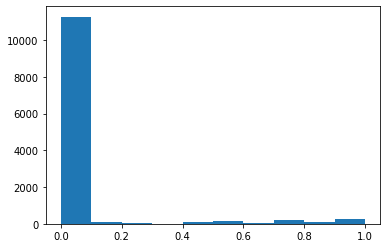

In [25]:
plt.hist(obs_recon[1].detach().cpu().permute([2,1,0]).numpy().flatten())

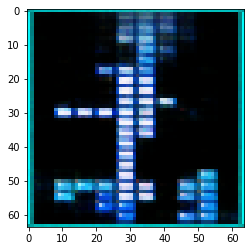

In [26]:
plt.imshow(obs_recon[0].detach().cpu().permute([2,1,0]))

In [29]:
logsigma

tensor([[-0.5438, -0.7394, -0.5222, -0.4991, -0.8286, -0.8451, -0.4577, -0.5124,
         -1.1785, -0.5304, -0.8110, -0.8364, -0.5332, -0.7920, -0.4304, -0.6321,
         -0.6537, -1.0195, -0.6118, -0.3482, -0.8745, -0.7966, -0.6762, -0.4042,
         -0.5558, -0.6207, -0.5258, -0.6704, -1.2830, -1.2789, -0.8485, -0.3977,
         -1.4178, -1.0898, -0.5221, -0.5487, -0.2642, -0.5655, -0.5596, -0.6060,
         -0.1720, -1.5619, -0.4163, -0.7385, -0.1902, -1.9787, -1.0747, -0.5009,
         -1.1062, -0.3682, -0.6088, -0.4914, -0.5530, -0.7331, -0.5068, -0.3708,
         -0.5749, -0.5715, -0.6199, -2.0547, -0.9009, -0.7439, -0.6286, -0.6881],
        [-0.4186, -0.1038, -0.1191, -0.1570, -0.3596, -0.2700, -0.1878, -0.4876,
         -0.8411, -0.2409, -0.3749, -0.4122, -0.3267, -0.2405, -0.0162, -0.0673,
         -0.1803, -0.4150, -0.1052, -0.4374, -0.5221, -0.2887, -0.3469, -0.0775,
         -0.0286, -0.2234, -0.2652, -0.3439, -0.5940, -1.2041, -0.7641, -0.1397,
         -0.9125, -0.5746, 

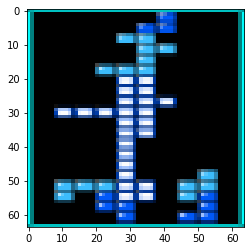

In [27]:
plt.imshow(obs_in[0].detach().cpu().permute([2,1,0]))